In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models import vgg11
import torch.autograd as ag


In [2]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg11_model = vgg11(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg11_model.features.children())[:35])

    def forward(self, img):
        out = self.feature_extractor(img)
        return out

feature_extractor = FeatureExtractor()


In [3]:
class Generator_CNN(nn.Module):
    def __init__(self):
        super(Generator_CNN, self).__init__()
        self.g_conv_n32s1_f = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_6 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n1s1 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, img):
        out = self.relu(self.g_conv_n32s1_f(img))
        out = self.relu(self.g_conv_n32s1_1(out))
        out = self.relu(self.g_conv_n32s1_2(out))
        out = self.relu(self.g_conv_n32s1_3(out))
        out = self.relu(self.g_conv_n32s1_4(out))
        out = self.relu(self.g_conv_n32s1_5(out))
        out = self.relu(self.g_conv_n32s1_6(out))
        out = self.relu(self.g_conv_n1s1(out)) 
        return out
    
generator = Generator_CNN()
print (type(generator))

<class '__main__.Generator_CNN'>


In [4]:

class Discriminator_CNN(nn.Module):
#     (nn.Module):
    def __init__(self, input_size=3):
        super(Discriminator_CNN, self).__init__()  # n-f/s +1, # 56*56*3   #32x32x3
        
        self.conv1 = nn.Conv2d(3,64,3,stride=1, groups=1) # 54*54*3    #30*30*3
        self.conv2 = nn.Conv2d(64,64,3,stride=2) # 26*26*64   #14*14*64         
        self.conv3 = nn.Conv2d(64,128,3,stride=1) #24*24*128   #12*12*128
        self.conv4 = nn.Conv2d(128,128,3,stride=2) #11*11*128  #5*5*128
        self.conv5 = nn.Conv2d(128,256,3,stride=1) #5*5*256    #3*3*256
        self.leaky = nn.LeakyReLU()
        self.fc1 = nn.Linear(2304,1024)
        self.fc2 = nn.Linear(1024,1)

        
    def forward(self, img):
        out = self.conv1(img)
        out = self.leaky(out)
        out = self.conv2(out)
        out = self.leaky(out)
        out = self.conv3(out)
        out = self.leaky(out)
        out = self.conv4(out)
        out = self.leaky(out)
        out = self.conv5(out)
        out = self.leaky(out)
        out = out.view(-1,self.num_flat_features(out))
        out = self.fc1(out)
        out = self.leaky(out)
        out = self.fc2(out)
        out = self.leaky(out)
        return out
    
    # Determine the number of features in a batch of tensors
    def num_flat_features ( self , x ):
        size = x.size()[1:]
        return np.prod(size)
    
dis = Discriminator_CNN()
print(dis)
print (dis.parameters)

Discriminator_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (leaky): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)
<bound method Module.parameters of Discriminator_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (leaky): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, 

In [5]:
def calc_gradient_penalty(discriminator, real_data, fake_data, lambda_):
    alpha = torch.rand(real_data.shape[2],1)
    alpha = alpha.cuda() if torch.cuda.is_available() else alpha #earya
    interpolates = (alpha * real_data + ((1-alpha) * fake_data))
    if torch.cuda.is_available():      
        interpolates = interpolates.cuda()
    print (type(interpolates))
    interpolates = ag.Variable(interpolates, requires_grad=True)
    disc_interpolates = discriminator(interpolates)
    gradients = ag.grad(outputs=disc_interpolates, inputs=interpolates, grad_outputs=torch.ones(disc_interpolates.size()).cuda() if torch.cuda.is_available() else torch.ones(disc_interpolates.size()), create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

In [6]:
LEARNING_RATE = 1e-5
LAMBDA_ = 10
d_min = -1024.0
d_max = 3072.0

In [7]:
criterion_perceptual = nn.L1Loss()
discriminator = Discriminator_CNN(input_size=55)
feature_extractor = FeatureExtractor()

In [8]:
%matplotlib inline
from PIL import Image
import torch
from torch import nn, optim
import torch.utils.data
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from zipfile import ZipFile
from io import BytesIO

# Image manipulation.
import PIL.Image
from IPython.display import display


def load_image(filename):
    image = PIL.Image.open(filename) # open colour image
    return (image)

def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    # Convert the pixel-values to the range between 0.0 and 1.0
#     image = np.clip(image/255.0, 0.0, 1.0) 
    plt.imshow(image, interpolation='lanczos')
    # Plot using matplotlib.
    plt.imshow(image)
    plt.show()
    
def normalize_images(x):
    ''' 
    This function normalizes input numpy ndarray x to range [-1,1]. 
    This could be done directly by using a linear function.
    param x :  input matrix
    rtype: float64 
    '''
    return 2*x.astype(np.float64)/255. -1

    
num_epoch = 50
howmany2load=2500
tessize = 50
batch_size = 10
B = batch_size
archive = ZipFile("./img_align_celeba.zip", 'r')
x_train=np.empty([howmany2load,32,32,3])
x_train_orig=np.empty([howmany2load,32,32,3])

for i in range(1,howmany2load): 
    image = load_image(filename=BytesIO(archive.read(archive.namelist()[i])))
    image = image.resize((32,32), PIL.Image.ANTIALIAS)
    x_train_orig[i,:,:]=np.array(image)
    

In [9]:
x_train = normalize_images(x_train_orig)

x_test=x_train[0:tessize,:,:,:]
x_train=x_train[tessize:-1,:,:,:]
print (x_test.shape)
print (x_train.shape)

noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 



x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)


(50, 32, 32, 3)
(2449, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


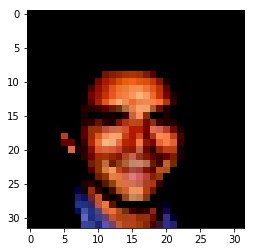

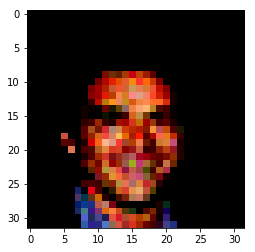

1.0

In [10]:
plot_image (x_train[0])
plot_image (x_train_noisy[0])
np.max(x_train[0])

In [11]:


generator.cuda()
discriminator.cuda()
feature_extractor.cuda()

criterion_GAN = nn.MSELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5,0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5,0.9))

one = torch.Tensor([1])
mone = one * -1
if torch.cuda.is_available():
    one = one.cuda()
    mone = mone.cuda()


# total_step = len(train_loader)
total_step = 10
type(generator)



__main__.Generator_CNN

In [12]:
print (len(x_train[1]))
print (x_train_noisy.shape)

32
(2449, 32, 32, 3)


In [13]:

x_ctrain = np.moveaxis(x_train, [0,1,2,3], [0,2,3,1])
x_ctest = np.moveaxis(x_test, [0,1,2,3], [0,2,3,1])
x_ctrain_noisy = np.moveaxis(x_train_noisy, [0,1,2,3], [0,2,3,1])
x_ctest_noisy = np.moveaxis(x_test_noisy, [0,1,2,3], [0,2,3,1])
del(x_train)
del(x_train_noisy)
x_ctest_noisy = ((x_ctest_noisy)*2-1)
x_ctrain_noisy = ((x_ctrain_noisy)*2-1)
x_ctest = ((x_ctest)*2-1)
x_ctrain = ((x_ctrain)*2-1)


for epoch in range(num_epoch):
      
    input_img0 = x_ctrain_noisy 
    target_img0 = x_ctrain 
    input_img1 = ag.Variable(torch.Tensor(input_img0), requires_grad=True)
    input_img2 = torch.Tensor(input_img0)
    input_img3 = torch.Tensor(input_img0).cuda()
    input_img = input_img1.type(torch.Tensor).cuda()
    target_img1 = torch.Tensor(target_img0)
    target_img = target_img1.type(torch.Tensor).cuda()

        # Train D
    D_ITER = 1
    optimizer_D.zero_grad()
    for i in range(D_ITER):
        
        N = howmany2load - (tessize+1)
        for l in range(0, (N+B-1)//B):
            idx =(np.arange(B*l, min(B*(l+1), N)))
            discriminator.zero_grad()
            temp = Variable(target_img[idx,:,:,:],requires_grad=False)
            d_real_decision = discriminator(temp)   ##? batch?? feed x_train
            del(temp)
            d_real_error = -torch.mean(d_real_decision)
            d_real_error.backward(retain_graph=True)

            # Train D on fake
            d_fake_data = generator(input_img[idx,:,:,:]).detach() ## ??? g(X) x_train_noisy ??
            d_fake_decision = discriminator(d_fake_data)
            d_fake_error = torch.mean(d_fake_decision)
            d_fake_error.backward()   ## ?????
    
        
        
        
        N = howmany2load - (tessize+1)
        for l in range(0, (N+B-1)//B):
            idx =(np.arange(B*l, min(B*(l+1), N)))
#             print(idx)
            real_data = target_img[idx,:,:,:]
            fake_data = input_img3[idx,:,:,:]
            lambda_ = 10
            alpha = torch.rand(real_data.shape[2],1)
            alpha = alpha.cuda() if torch.cuda.is_available() else alpha
            interpolates = (alpha * real_data + ((1-alpha) * fake_data))
            if torch.cuda.is_available():
                interpolates = interpolates.cuda()
            interpolates = ag.Variable(interpolates, requires_grad=True)
            disc_interpolates = discriminator(interpolates)
            gradients = ag.grad(outputs=disc_interpolates.float(), inputs=interpolates, grad_outputs=torch.ones(disc_interpolates.size()).cuda() if torch.cuda.is_available() else torch.ones(disc_interpolates.size()), create_graph=True, retain_graph=True, only_inputs=True)[0]
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_
            d_error = d_fake_error - d_real_error + gradient_penalty
    
    
        optimizer_D.step()
        
#     print ("Discriminator training complete")
    optimizer_G.zero_grad()
        # Train G
    generator.zero_grad()
    g_fake_data = generator(input_img[idx,:,:,:])     ## noisy img
    dg_fake_decision = discriminator(g_fake_data)
    g_error = -torch.mean(dg_fake_decision)

    fake_data_dup = d_fake_data
    real_data_dup = Variable(target_img[idx,:,:,:], requires_grad=False)
    fake_features = feature_extractor(fake_data_dup)
    real_features = (feature_extractor(real_data_dup))#, requires_grad=False)
    perceptual_error = criterion_perceptual(fake_features, real_features.detach())
    
    
    g_perceptual_error = g_error + (0.1 * perceptual_error)   ## LAMBDA 1
    g_perceptual_error.backward()
    optimizer_G.step()
   
    
        
        


In [14]:
torch.save(generator.state_dict(), 'wgan.h5')

In [15]:
list(generator.parameters())


[Parameter containing:
 tensor([[[[ 0.0547,  0.0076, -0.0048],
           [ 0.0147,  0.0719, -0.1399],
           [ 0.0446,  0.0951, -0.0198]],
 
          [[-0.1683,  0.1308, -0.1399],
           [-0.0652,  0.1703,  0.1633],
           [-0.0763, -0.1528,  0.0302]],
 
          [[-0.0895, -0.0781,  0.0287],
           [ 0.1911, -0.0080,  0.0813],
           [-0.0089,  0.1812, -0.1797]]],
 
 
         [[[ 0.1823,  0.0828, -0.1309],
           [-0.0199, -0.0473, -0.0142],
           [ 0.0497, -0.1758,  0.1883]],
 
          [[ 0.1397,  0.1136, -0.0432],
           [-0.0336, -0.0241,  0.1791],
           [ 0.0226,  0.0231, -0.1461]],
 
          [[ 0.1378, -0.0036,  0.1879],
           [ 0.1355, -0.0289,  0.1372],
           [-0.0746, -0.1550, -0.0125]]],
 
 
         [[[-0.0886, -0.0718, -0.1565],
           [-0.0925,  0.0991, -0.0559],
           [ 0.0750,  0.1423,  0.0893]],
 
          [[ 0.1827, -0.0492, -0.1102],
           [ 0.0719,  0.1876,  0.0386],
           [-0.1599, -0.1454, 

In [16]:
list(generator.parameters())

[Parameter containing:
 tensor([[[[ 0.0547,  0.0076, -0.0048],
           [ 0.0147,  0.0719, -0.1399],
           [ 0.0446,  0.0951, -0.0198]],
 
          [[-0.1683,  0.1308, -0.1399],
           [-0.0652,  0.1703,  0.1633],
           [-0.0763, -0.1528,  0.0302]],
 
          [[-0.0895, -0.0781,  0.0287],
           [ 0.1911, -0.0080,  0.0813],
           [-0.0089,  0.1812, -0.1797]]],
 
 
         [[[ 0.1823,  0.0828, -0.1309],
           [-0.0199, -0.0473, -0.0142],
           [ 0.0497, -0.1758,  0.1883]],
 
          [[ 0.1397,  0.1136, -0.0432],
           [-0.0336, -0.0241,  0.1791],
           [ 0.0226,  0.0231, -0.1461]],
 
          [[ 0.1378, -0.0036,  0.1879],
           [ 0.1355, -0.0289,  0.1372],
           [-0.0746, -0.1550, -0.0125]]],
 
 
         [[[-0.0886, -0.0718, -0.1565],
           [-0.0925,  0.0991, -0.0559],
           [ 0.0750,  0.1423,  0.0893]],
 
          [[ 0.1827, -0.0492, -0.1102],
           [ 0.0719,  0.1876,  0.0386],
           [-0.1599, -0.1454, 

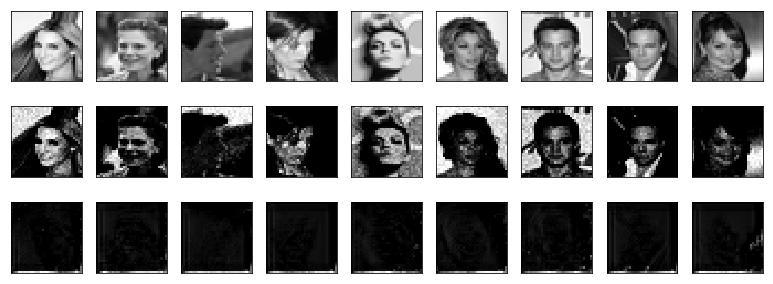

In [17]:
import matplotlib.pyplot as plt
d = generator.cpu()((torch.Tensor(x_ctest_noisy)*2-1)*100)
#d = generator.cpu()(torch.Tensor(x_ctest_noisy))
a = d.data.numpy()
a = np.moveaxis(a,[0,1,2,3],[0,3,1,2])
a.shape
generator = generator.cuda()
import skimage
from skimage.color import rgb2gray
n = 10
plt.figure(figsize=(15, 5))
for i in range(1,n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(rgb2gray(x_test[i,:,:,:]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(rgb2gray(x_test_noisy[i,:,:,:]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, n, i+2*n)
    plt.imshow(rgb2gray(a[i,:,:,:]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()
#print('psnr of noisy test images')
#plt.plot(psnr_before[0:20])
#plt.show()
#print('psnr of denoised images')
#plt.plot(psnr_after[0:20])
#plt.show()
#print(psnr_before.min)
#print(psnr_after.min)